In [39]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg' #svg
import pylab as plb
import numpy as np
import scipy as sp
import flylib as flb
import group_data as gd
plb.rcParams['pdf.fonttype'] = 42 #allows text in saved .pdf files to be edited in illustrator
plb.rcParams['image.interpolation'] = 'Nearest'
plb.rcParams['image.cmap'] = 'BrBG'
recalc_means = False #recalculate the groupwise mean stats set to False to load from file

In [2]:
import plotfuncs as plf

In [3]:
import h5py
trial_db = h5py.File('../02_imaging_post_processing/trial_db.hdf5','a')

In [4]:
# function to get the timebase using the trial name (yaw_left)
def get_xio(trial_name):
    xi = np.linspace(0,23,1150)
    #print trial_name
    if trial_name in ['ascending','descending','yaw_left','yaw_right','progressive','regressive']:
        xi -= 10.0
    if 'pth_roll' in trial_name:
        xi -= 7.0
    if 'flight' in trial_name:
        xi -= 5.0
    else:
        return xi
    return xi

In [5]:
trial_types = set(trial_db['trial_names'])
test_set = list(trial_types.difference(['flight_starts','flight_stops','stripe_fix']))
fly_set = set(gd.GMR22H05_list)

In [6]:
#mask out the data so only the trial types in test_set will be included we dont want to look
#at stripe fixation, or flight initataion or termination events
mask = np.zeros(np.shape(trial_db['trial_names'])[0]).astype(bool)
for trial_name in test_set:
    mask = mask | (np.array(trial_db['trial_names']) == trial_name)

#now mask out the data to only include the flys in gd.GRM22H05_list
fly_mask = np.zeros_like(mask,dtype = bool)
for fly in fly_set:
    fly_mask = fly_mask | (np.array(trial_db['fly_numbers']) == fly)

#update the mask    
mask = mask & fly_mask

# Create a selection array to include only epochs with flight for for the entire trial - i.e. the number of samples
# with a wing-beat frequency > 100  was equal to the number of samples in the trial
flt_selection = np.nansum(np.array(trial_db['wb_frequency']) > 100,axis = 1)>=np.shape(trial_db['wb_frequency'])[1]
mask = mask & flt_selection

/home/psilentp/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in greater


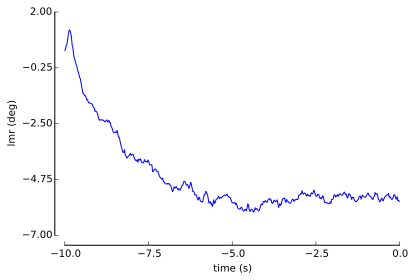

In [51]:
#On swiching from closed-loop to open-loop the fly drifts into a leftward turn 
#that reaches steady-state at around 4 sec. 
xi = get_xio('yaw_right')
prestim_lmr = np.mean(np.array(trial_db['Ph2'][mask,:])[:,xi<0],axis = 0)
plb.plot(xi[xi<0],gd.signal_plot_info['Ph2']['transform'](prestim_lmr))
plf.pull_ax_spines()
plb.gca().set_ylabel('lmr (deg)')
plb.gca().set_xlabel('time (s)')

In [7]:
!rm open_loop_trial_db.hdf5

In [8]:
#subtract from all responses to the mean and
#normalize by the variance taken during the three 
#seconds prior to stimulus onset on a per fly basis
mtd = h5py.File('open_loop_trial_db.hdf5','a')

def get_norm_term(signal,mask = mask,xi_range = (-3,0),xio_trial_name = 'yaw_left'):
    """get the norm of value over the samples in the time range xi_range 
    for the data in the matrix 'signals' with rows selected by mask. trial_name is
    used to determine the mapping from samples to times in xi_range"""
    data_selection = trial_db[signal][mask,:]
    xi = get_xio(trial_name)
    baseline_mask = (xi>xi_range[0]) & (xi<[xi_range[1]]) 
    subtracted_selection = data_selection-np.mean(data_selection[:,baseline_mask],axis = 1)[:,np.newaxis]
    return np.nanstd(subtracted_selection[:,baseline_mask])

In [9]:
#create dictionary to store the normalization values
signal_norms = dict()
#the signal norms will be computed for the 'matrix' like signals, init with a blank selection mask
[signal_norms.update({signame:np.zeros_like(mask)}) for signame,dset in trial_db.items() if (np.ndim(dset)>1)];
#create a vector of norm values for each trial
for fly in fly_set: #loop over all the flies in fly_set
    fly_selection_mask = np.array(trial_db['fly_numbers']) == fly #create a selection mask for the fly
    for sig_key,norm_array in signal_norms.items(): #loop over all the signals
        norm_val = get_norm_term(sig_key,mask = fly_selection_mask,xio_trial_name = 'yaw_left')
        signal_norms[sig_key] = norm_array + (fly_selection_mask*norm_val) #add in the normalization values

In [10]:
#dataset to hold the normalized data
mtd.create_group('normed_signals')
#also save a copy of the untransformed data 
mtd.create_group('selected_signals')

<HDF5 group "/selected_signals" (0 members)>

In [11]:
#create mean subtracted and normalized datasets for each of the 'matrix' like signals
for k in signal_norms.keys():
    ssig = trial_db[k][mask,:]
    flb.update_dset(mtd['selected_signals'],k,ssig)
    xi = get_xio('yaw_left')
    baseline_idx = xi<0
    nsig = (ssig - np.nanmean(ssig[:,baseline_idx],axis = 1)[:,np.newaxis])/signal_norms[k][mask][:,np.newaxis]
    flb.update_dset(mtd['normed_signals'],k,nsig)

/home/psilentp/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in divide


In [12]:
#now apply the mask selection to the trial description vectors and store
for key,dset in trial_db.items():
    if (np.ndim(dset)<2):
        if not(key == u'signal_units'):
            flb.update_dset(mtd['selected_signals'],key,dset[mask])

In [13]:
def get_trial_mtrx(signal,trial):
    """pull out a matrix for a single trial type from the normalized datasets"""
    selection = np.array(mtd['selcted_signals']['trial_names']) == trial
    return mtd['normed_signals'][signal][selection,:]

In [14]:
#use the left-right amplitude (Ph2) as the sort index
stim_ep = (0,3)
sig = np.array(mtd['normed_signals']['Ph2'])
sort_idx = np.argsort(np.mean(sig[:,(xi>stim_ep[0]) & (xi<stim_ep[1])],axis = 1))[::-1] #reverse ordered
flb.update_dset(mtd,'sort_idx',sort_idx)

In [15]:
#resort all of the columns in the dataset by sort idx - will make life easier in the future
for key,value in mtd['normed_signals'].items():
    mtd['normed_signals'][key][:] = np.array(mtd['normed_signals'][key])[mtd['sort_idx']]

In [16]:
#apply the same sorting to the description vectors
for key,value in mtd['selected_signals'].items():
    mtd['selected_signals'][key][:] = np.array(mtd['selected_signals'][key])[mtd['sort_idx']]

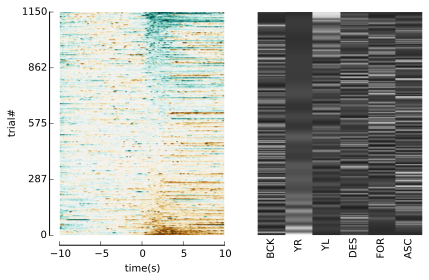

In [41]:
#Check to see if trials are sorted correctly and examine
# how the trial types are co-sorted by lmr response
plb.figure(figsize = (6.5,4))
plb.subplot(1,2,1)
shp = np.shape(mtd['normed_signals']['Ph2'])
plb.imshow(mtd['normed_signals']['Ph2'],
           aspect = 'auto',
           vmin = -6,vmax = 6,
           extent = (xi[0],xi[-1],shp[0],shp[1]))
plb.gca().set_xbound(-10,10)
plf.pull_ax_spines(xtick_numbers = 5)
bnds = plb.gca().get_ybound()
plb.gca().set_yticklabels(np.linspace(0,bnds[-1],5,dtype = int));
plb.gca().set_xlabel('time(s)')
plb.gca().set_ylabel('trial#')
plb.subplot(1,2,2)
trial_list = list(set(mtd['selected_signals']['trial_names']))

def smooth_inter_fun(r):
    from scipy import interpolate
    s = interpolate.UnivariateSpline(np.arange(len(r)), r)
    s.set_smoothing_factor(120)
    xnew = np.arange(0, len(r)-1, .1)
    return s(xnew)

trial_mtrx = [smooth_inter_fun((np.array(mtd['selected_signals']['trial_names']) == sig)) for sig in trial_list]

plb.imshow(np.array(trial_mtrx).T[::-1],aspect = 'auto',cmap = plb.cm.gray)
plf.kill_spines()
trial_list = [gd.trial_to_label[tr] for tr in trial_list]
trial_list = [None] + trial_list
plb.gca().set_xticklabels(trial_list,rotation = 90)
[x.set_visible(True) for x in plb.gca().get_xticklabels()]

plb.gca().get_xaxis().majorTicks[1].label1.set_horizontalalignment('center')

In [52]:
trial_db.close()
mtd.flush()
mtd.close()